# CTRL-RANSAC
We propose a method for making inferences on outliers detected by RANSAC Regression using Selective Inference. Our goal is to perform statistical tests on each detected outlier to determine whether it is a true outlier. Given the potential bias in the parameters of interest, we introduce the selective p-value to mitigate this bias and control the False Positive Rate (FPR) at the significance level $\alpha$. Below, we provide a detailed step-by-step explanation of our approach, along with a sample code.


### Preparation
Initially, we set the values for the parameters

In [1]:
n = 50  # int: number of instances
p = 1  # int: number of features
B = 10  # int: number of iterations in RANSAC
t = 5  # float: Threshold
num_outliers = 4  # int: number of outliers in the simulated dataset
delta = 4  # float: outlier shift

### Generate a dataset and apply RANSAC to it
We import two custom functions that we developed: one for generating data and another for applying RANSAC.

In [22]:
from gendata import gen  # generate dataset for linear regression problem
from regressor import RANSAC # RANSAC Regressor
# Our gen function will randomly generate the indices of outliers.
X, y, true_outliers = gen(n, p, num_outliers, delta)
model = RANSAC(B, t)
model.fit(X, y)

Let's examine the RANSAC results and compare them with the actual generated outliers. Please note that the indices provided in the list of outliers are 0-based.

In [23]:
print("Detected outliers = ", model.best_outliers)

Detected outliers =  [5, 13, 35, 47, 49]


### Apply CTRL-RANSAC to make inference on every outliers

In [24]:
import CTRL_RANSAC # our proposed method to identify truncation region
import util
list_of_outliers = model.best_outliers
Selective_pvalues = {} # We store the p-values in a dictionary for easier demonstration
for j in list_of_outliers:
    etaT_yobs, etaT_Sigma_eta, a, b = util.calculate_SI_essentials(X, y, list_of_outliers, j)
    truncatedRegion = CTRL_RANSAC.identifying_truncated_region(model, X, a, b)
    p_value = util.calculate_p_value(truncatedRegion, etaT_yobs, etaT_Sigma_eta)
    Selective_pvalues[j] = p_value

Let's see the result:

In [25]:
for i in list_of_outliers:
    p_value = Selective_pvalues[i]
    print(f"The p-value of {i + 1}(th) instance is: {p_value}")

The p-value of 6(th) instance is: 1.6381475877265814e-05
The p-value of 14(th) instance is: 0.19848081987992483
The p-value of 36(th) instance is: 0.009763878039193985
The p-value of 48(th) instance is: 0.00024750478477943063
The p-value of 50(th) instance is: 5.0198947396605e-05


In the following plot
- True outlier: A genuinely abnormal data point
- Inlier: A normal data point
- Misclassified inlier: A normal data point incorrectly classified as an outlier.

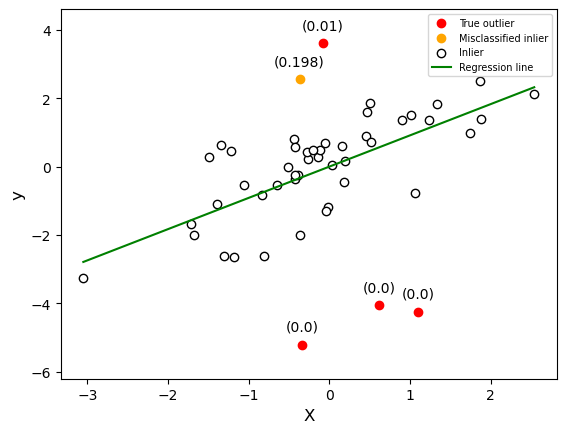

In [26]:
trueOutliersDetected = []
trueOutliers_pvalues = []
misclassified_inliner = []
misclassified_inliner_pvalues = []
normal_points = []
for i in range(n):
    if i in list_of_outliers:
        p_value = Selective_pvalues[i]
        if i in true_outliers:
            trueOutliersDetected.append(i)
            trueOutliers_pvalues.append(p_value)
        else:
            misclassified_inliner.append(i)
            misclassified_inliner_pvalues.append(p_value)
    else:
        normal_points.append(i)

import matplotlib.pyplot as plt
import numpy as np

plt.scatter(X[trueOutliersDetected], y[trueOutliersDetected], color = "red", label = "True outlier")
plt.scatter(X[misclassified_inliner], y[misclassified_inliner], color = "orange", label = "Misclassified inlier")
plt.scatter(X[normal_points], y[normal_points], facecolor = "white", edgecolor = "black", label = "Inlier")
plt.plot(np.linspace(min(X), max(X), 100), model.predict(np.linspace(min(X), max(X), 100).reshape((100, p))), color = "green", label = "Regression line")
for i in range(len(trueOutliersDetected)):
    plt.annotate(f'({round(trueOutliers_pvalues[i], 3)})', (X[trueOutliersDetected[i]], y[trueOutliersDetected[i]]), textcoords="offset points", xytext=(0, 10), ha='center')
for i in range(len(misclassified_inliner)):
    plt.annotate(f'({round(misclassified_inliner_pvalues[i], 3)})', (X[misclassified_inliner[i]], y[misclassified_inliner[i]]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel("X", size = 12)
plt.ylabel("y", size = 12)
plt.legend(fontsize = 7)
plt.ylim(min(y) - 1, max(y) + 1)
plt.savefig("./results/demonstration")